# Instant-ngp

This notebook aims to be a step-by-step guide to train NeRF models and rendering videos from them with nvidia's [instant-ngp](https://github.com/NVlabs/instant-ngp) software using:
 * **Colab** for the heavy lifting.
 * A low-resource **local computer** for the steps that require having a graphical user interface (GUI).

It has been tested on a GTX 1050ti in the local machine and an assigned Tesla T4 in the remote one.



## 1.Connect to a GPU runtime

Connect your colab session to a GPU runtime and check that you have been assigned a GPU. It should have a minimum of 8GB of available memory.

In [ ]:
!nvidia-smi

Mon May 13 18:16:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 2. Install dependencies and clone the instant-ngp repo

In [ ]:
!apt update && apt install build-essential git python3-dev python3-pip libopenexr-dev libxi-dev libglfw3-dev libglew-dev libomp-dev libxinerama-dev libxcursor-dev colmap ffmpeg jq
!pip install --upgrade cmake

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [830 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,798 kB]
Get:13 http://securi

In [ ]:
!git clone --recursive https://github.com/nvlabs/instant-ngp
%cd instant-ngp

Cloning into 'instant-ngp'...
remote: Enumerating objects: 4318, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 4318 (delta 94), reused 134 (delta 73), pack-reused 4100
Receiving objects: 100% (4318/4318), 187.20 MiB | 29.78 MiB/s, done.
Resolving deltas: 100% (2721/2721), done.
Updating files: 100% (368/368), done.
Submodule 'dependencies/OpenXR-SDK' (https://github.com/KhronosGroup/OpenXR-SDK.git) registered for path 'dependencies/OpenXR-SDK'
Submodule 'dependencies/args' (https://github.com/Taywee/args) registered for path 'dependencies/args'
Submodule 'dependencies/dlss' (https://github.com/NVIDIA/DLSS) registered for path 'dependencies/dlss'
Submodule 'dependencies/glfw' (https://github.com/Tom94/glfw) registered for path 'dependencies/glfw'
Submodule 'dependencies/imgui' (https://github.com/ocornut/imgui.git) registered for path 'dependencies/imgui'
Submodule 'dependencies/pybind11' (https://github.com/Tom94/

## 3. Set compute capability
Find the compute capability of the GPU in your **local** machine in the following link:
https://developer.nvidia.com/cuda-gpus

You need this to be able to open your trained models in `testbed` inside your local machine later on, so you can explore them or trace a camera path in order to generate a video from your scene.

In [ ]:
compute_capability = "75" #@param [50, 52, 60, 61, 70, 72, 75, 80, 86, 87]
%env TCNN_CUDA_ARCHITECTURES=$compute_capability


env: TCNN_CUDA_ARCHITECTURES=75


## 4. Set the right network configuration
For compatibility between the model trained here and the local machine, a network with FP32 or FP16 is chosen.

https://docs.nvidia.com/deeplearning/tensorrt/support-matrix/index.html#hardware-precision-matrix

In [ ]:
network_type = "FullyFusedMLP" if int(compute_capability) >= 70 else "CutlassMLP"
print(f"Using {network_type}")
%env NN_CONFIG_PATH = ./configs/nerf/base.json
!jq '.network.otype = "CutlassMLP" | .rgb_network.otype = "CutlassMLP"' $NN_CONFIG_PATH | sponge $NN_CONFIG_PATH

Using FullyFusedMLP
env: NN_CONFIG_PATH=./configs/nerf/base.json


## 5. Build the project and install python requirements

In [ ]:
!cmake . -B build -DNGP_BUILD_WITH_GUI=OFF

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- The CUDA compiler identification is NVIDIA 12.2.140
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- No release type specified. Setting to 'Release'.
-- Obtained CUDA architectures from environment variable TCNN_CUDA_ARCHITECTURES=75
-- Targeting CUDA architectures: 75
-- Module support is disabled.
-- Version

In [ ]:
!cmake --build build --config RelWithDebInfo -j `nproc`

[  2%] Building CUDA object CMakeFiles/optix_program.dir/src/optix/pathescape.ptx
[  5%] Building CXX object dependencies/tiny-cuda-nn/dependencies/fmt/CMakeFiles/fmt.dir/src/format.cc.o
[  7%] Building CUDA object CMakeFiles/optix_program.dir/src/optix/raystab.ptx
[ 10%] Building CUDA object CMakeFiles/optix_program.dir/src/optix/raytrace.ptx
[ 10%] Built target optix_program
[ 13%] Building CXX object dependencies/tiny-cuda-nn/dependencies/fmt/CMakeFiles/fmt.dir/src/os.cc.o
[ 15%] Linking CXX static library libfmt.a
[ 15%] Built target fmt
[ 18%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/common_host.cu.o
[ 21%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/cpp_api.cu.o
[ 23%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/cutlass_mlp.cu.o
[ 26%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/encoding.cu.o
[ 28%] Building CUDA object dependencies/tiny-c

In [ ]:
!pip3 install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.2/276.2 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for commentjson: filename=commentjson-0.9.0-py3-none-any.whl size=12074 sha256=bcdba10ca1eb8792b43a663863f9d7cd00325979ff4a110e19d7f0f0b13f07cd
  Stored in directory: /root/.cache/pip/wheels/7d/90/23/6358a234ca5b4ec0866d447079b97fedf9883387d1d7d074e5
  Created wheel for lark-parser: filename=lark_parser-0.7.8-py2.py3-none-any.whl size=62510 sha256=e22599848ddac595a5db935635fd539a86f60bd41150e541d25f08b4cf897ae6
  Stored in directory: /root/.cache/pip/wheels/29/30/94/33e8b58318aa05cb1842b365843036e0280af5983abb966b83
Successfully built commentjson lark-parser


## 6. [LOCAL MACHINE] Run COLMAP on your scene
COLMAP doesn't work on machines without a GUI.

Go to your local machine and follow the [instructions](https://github.com/NVlabs/instant-ngp/blob/master/docs/nerf_dataset_tips.md#preparing-new-nerf-datasets) to run COLMAP from a video or a set of images to generate camera positions from your scene.

After this, you should have an images folder, with the images of your scene, and a `transforms.json` file with the camera information extracted by COLMAP.

## 7. Upload your scene

Mount your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Then upload the `images` folder and the output of COLMAP, `transforms.json`, to your drive. The structure should be similar to the following:
```
/content/drive/MyDrive/nerf_scenes/
└── fox
    ├── images
    │   ├── 00001.jpg
    │   └── 00002.jpg
    └── transforms.json
```



In [ ]:
import os
scene_path = "/content/drive/MyDrive/getnerfed/hall" #@param {type:"string"}
if not os.path.isdir(scene_path):
  raise NotADirectoryError(scene_path)

In [ ]:
!cp -r "/content/drive/MyDrive/getnerfed/hall_blurred_background/images" "/content/hall_blur/images"
#!cp -r "/content/drive/MyDrive/getnerfed/notre_dame/resized_images" "/content/new_notre_dame/images"

# **Creating Pre-Processing pipeline**

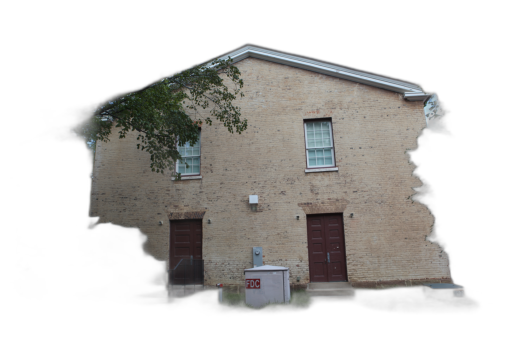

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

images_path = scene_path + "/images"

# Get a list of files in the directory
file_list = os.listdir(images_path)

# Filter out only image files (assuming all files are images)
image_files = [f for f in file_list if f.endswith(".jpg") or f.endswith(".png")]

# Check if there are any image files in the directory
if len(image_files) == 0:
    print("No image files found in the directory.")
else:
    # Sort the image files for consistency
    image_files.sort()

    # Open and display the first image using matplotlib
    first_image_path = os.path.join(images_path, image_files[0])
    first_image = Image.open(first_image_path)
    plt.imshow(first_image)
    plt.axis('off')  # Turn off axis
    plt.show()

In [ ]:
scene_path

'/content/drive/MyDrive/getnerfed/notre_dame'

In [ ]:
processed_images_folder = "processed_images"
processed_images_path = os.path.join(scene_path, processed_images_folder)

In [ ]:
deleted = 0

for image_file in image_files:
  # Open the image
  image_path = os.path.join(images_path, image_file)
  image = Image.open(image_path)

  # Check if the image is vertical
  if image.height < image.width:
    os.remove(image_path)
    deleted += 1

print("Deleted images: ", deleted)

Deleted images:  0


In [ ]:
import cv2
import numpy as np

for image_file in image_files[:2]:
  # Open the image
  image_path = os.path.join(images_path, image_file)
  image = cv2.imread(image_path)

  # Display the original image
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title("Original Image")

"""
  # Check if the image is vertical
  if image.shape[0] > image.shape[1]:
      # Apply GrabCut algorithm to remove the background
      mask = np.zeros(image.shape[:2], np.uint8)
      bgd_model = np.zeros((1, 65), np.float64)
      fgd_model = np.zeros((1, 65), np.float64)
      rect = (10, 10, image.shape[1] - 10, image.shape[0] - 10)  # Rough rectangle around the foreground
      cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

      # Create mask where sure and likely foreground are 1, everything else is 0
      mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

      # Apply mask to original image
      result = image * mask2[:, :, np.newaxis]

      # Save processed image
      processed_image_path = os.path.join(processed_images_path, image_file)
      cv2.imwrite(processed_image_path, result)

      # Visualize the processed image
      processed_image = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
      plt.imshow(processed_image)
      plt.axis('off')
      plt.title("Processed Image")
      plt.show()

      print(f"Background removed from {image_file} and saved as {processed_image_path}.")

  else:
      print(f"{image_file} is horizontal and skipped.")
"""

NameError: name 'image_files' is not defined

## 8. Train a model on your scene!

In [ ]:
path = '/content/'
path

'/content/'

In [ ]:
scene_path

'/content/hall_blur'

In [ ]:
scene_path = '/content/hall_blur'

In [ ]:
train_steps = 1000  #@param {type:"integer"}
snapshot_path = os.path.join(path, f"{train_steps}.ingp")
!python ./scripts/run.py {scene_path} --n_steps {train_steps} --save_snapshot {snapshot_path}

18:48:47 SUCCESS  Initialized CUDA 12.2. Active GPU is #0: Tesla T4 [75]
18:48:47 INFO     Loading NeRF dataset from
18:48:47 INFO       /content/drive/MyDrive/getnerfed/hall/transforms.json
18:48:47 PROGRESS []   0% ( 0/98)  0s/inf18:48:47 PROGRESS []   1% ( 1/98)  0s/39s18:48:47 PROGRESS []   2% ( 2/98)  0s/20s18:48:48 PROGRESS []   3% ( 3/98)  0s/26s18:48:48 PROGRESS []   4% ( 4/98)  0s/21s18:48:48 PROGRESS []   5% ( 5/98)  1s/25s18:48:48 PROGRESS []   6% ( 6/98)  1s/21s18:48:49 PROGRESS []   7% ( 7/98)  1s/24s18:48:49 PROGRESS []   8% ( 8/98)  1s/22s18:48:49 PROGRESS []   9% ( 9/98)  2s/23s18:48:49 PROGRESS []  10% (10/98)  2s/22s18:48:50 PROGRESS []  11% (11/98)  2s/23s18:48:50 PROGRESS []  12% (12/98)  2s/22s18:48:50 PROGRESS []  13% (13/98)  3s/25s18:48:50 PROGRESS []  14% (14/98)  3s/24s18:48:51 PROGRESS []  15% (15/98)  4s/27s18:48:51 PROGRESS []  16% (16/98)  4s/25s18:48:52 PROGRESS []  17% (17/98)  4s/28s18:48:52 PROGRESS []  18% (18/98)  5s/27s18:48:53 PROGRESS []  19% (19/

## 9. [LOCAL MACHINE] Generate a camera path

Congrats! You now have a trained nerf checkpoint. Now, in order to generate a video with it, you will need to open it in your local machine with `testbed` and generate a `base_cam.jon` file following these [instructions](https://github.com/NVlabs/instant-ngp#testbed-controls). Remember to launch with the `--no-train` argument so that it doesn't start to train on your PC. Setting up the cameras can make your GUI pretty laggy, you can try to play with the `--height` and `--width` parameters or cropping your scene with the `Crop aabb` options to optimize the performance.

Example command:
```
./build/instant-ngp /data/nerf/fox/2000.ingp
```

After you're done, **upload `base_cam.json` to the root folder of your scene.**

## 10. Render video

Make sure `base_cam.json` exists:

In [ ]:
video_camera_path = os.path.join(scene_path, "base_cam.json")
if not os.path.isfile(video_camera_path):
  raise FileNotFoundError(video_camera_path)

FileNotFoundError: /content/base_cam.json

Render the video

In [ ]:
video_n_seconds = 5 #@param {type:"integer"}
video_fps = 25 #@param {type:"integer"}
width = 720 #@param {type:"integer"}
height = 720 #@param {type:"integer"}
output_video_path = os.path.join(scene_path, "output_video.mp4")

!python scripts/run.py {snapshot_path} --video_camera_path {video_camera_path} --video_n_seconds 2 --video_fps 25 --width 720 --height 720 --video_output {output_video_path}
print(f"Generated video saved to:\n{output_video_path}")

18:13:03 SUCCESS  Initialized CUDA 12.2. Active GPU is #0: Tesla T4 [75]
18:13:03 ERROR    File '/content/10000.ingp' does not exist.
Training:   0% 0/35000 [00:00<?, ?steps/s, loss=0]
Traceback (most recent call last):
  File "/content/instant-ngp/scripts/run.py", line 197, in <module>
    t.reset()
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1380, in reset
    self.refresh()
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1495, in display
    self.sp(self.__str__() if msg is None else msg)
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 459, in print_status
    fp_write('\r' + s + (' ' * max(last_len[0] - len_s, 0)))
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 452, in fp_write
    fp.write(str(s))
  File "/usr/local/lib/python3.10/dist-packages/tqdm/utils.py", line 196, in inner
    return func(*args